# CNN Connect 4 Model
[How AlphaGo works](https://jonathan-hui.medium.com/alphago-how-it-works-technically-26ddcc085319)

**How to use your gpu**

run this in a terminal
```
python -m venv ~/venv-tfmetal
source ~/venv-tfmetal/bin/activate
python -m pip install --upgrade pip
python -m pip install tensorflow
python -m pip install tensorflow-metal
python -m pip install jupyterlab
python -m pip install ipykernel
python -m ipykernel install --user --name=tfmetal --display-name "Python (tfmetal)"
```
Now select the new kernel "Python (tfmetal)" when you open jupyter lab

If you need to install additional packages, then activate the environment again and install the required packages:

```
source ~/venv-tfmetal/bin/activate
pip install pandas numpy tensorflow keras-tuner matplotlib scikit-learn
pip list
```

To share depdencies for future use:
```
pip freeze > requirements.txt
pip install -r requirements.txt
```

In [2]:
# Install if needed
# ! pip install keras_tuner

# libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
import pickle

In [3]:
# check which device you're using
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [4]:
# dataset
# df = pd.read_pickle('data/6-7-2shape_cleaned_subset.pkl') # smaller
df = pd.read_pickle('data/6-7-2shape_cleaned.pkl')

In [5]:
x = df["x"]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 22)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Things to try when tuning:
- multiple convolutional layers
- different filter sizes
- different number of filters
- multiple max pool layers,
    - **Should we not have max pooling?**
- several dense layers
- regularizers
- dropout layers
- **different batch sizes or number of epochs**
    - Should we change batch size and number of epochs?
- **could add batch normalization?**


Should you change dropout level between layers or keep it the same?

What is the best place to put dropout? Between any two layers?

Should regularization be done between layers or just at the very end?

In [6]:
def model_builder(hp):
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(6, 7, 2)))  # Input shape is (height=6, width=7, channels=2)

    # Determine the number of convolution and max pooling layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=5, step=1)

    for i in range(num_conv_layers):
        # Convolutional layer
        kernel_size_height = hp.Int('conv_kernel_size_'+str(i)+'_height', min_value=2, max_value=6, step=1)
        kernel_size_width = hp.Int('conv_kernel_size_'+str(i)+'_width', min_value=2, max_value=6, step=1)
        # stride = hp.Choice('conv_strides_'+str(i), values=[1, 2])

        model.add(layers.Conv2D(
            filters=hp.Choice('conv_filters_'+str(i), values=[32, 64, 128, 256]),
            kernel_size=(kernel_size_height, kernel_size_width),
            # strides=(stride, stride),
            activation=tf.nn.relu,
            padding='same'  # Ensure padding to avoid output size issues
            )
        )

        # # Optional max pooling layer
        # maxpool_size_height = hp.Int('maxpool_size_'+str(i)+'_height', min_value=1, max_value=4, step=1)
        # maxpool_size_width = hp.Int('maxpool_size_'+str(i)+'_width', min_value=1, max_value=4, step=1)
        # model.add(layers.MaxPooling2D(
        #     pool_size=(maxpool_size_height, maxpool_size_width),
        #     strides=(1, 1),  # Set strides to 1 so the pooling size is applied as is
        #     padding='same'   # Ensure padding to keep output dimensions valid
        #     )
        # )

    model.add(layers.Flatten())

    # Determine number of dense layers to use (with regularization and dropout)
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=6, step=1)
    for i in range(num_dense_layers):
        model.add(layers.Dense(
            hp.Int('dense_units_'+str(i), min_value=32, max_value=128, step=32),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.l2(
                hp.Choice('l2_reg_dense_'+str(i), values=[0.00001, 0.0001, 0.005, 0.01])
                )
            )
        )
        # Optional droppout (could set to 0)
        model.add(layers.Dropout(
            hp.Float('dropout_'+str(i), min_value=0.1, max_value=0.4, step=0.1)
            )
        )

    model.add(layers.Dense(7,activation=tf.nn.softmax))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate = hp.Choice('learning_rate', values = [0.1, 0.001, 0.0001])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
# now we have a tunable model; set up kt.Hyperband
# hyperband paper: https://arxiv.org/pdf/1603.06560

tuner = kt.Hyperband(model_builder,
                    objective = 'val_accuracy',
                    max_epochs = 10,
                    factor = 3,
                    hyperband_iterations=2,
                    directory = 'cnn_tuning',
                    project_name = 'cnn_tuning_kt_NoPooling'#,
                    #overwrite=True
                    )

# worse, don't use
# tuner = kt.BayesianOptimization(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=30,  # Adjust based on how many combinations you want to explore
#     directory='cnn_tuning',
#     project_name='cnn_bayesian_tuning'
# )


Reloading Tuner from cnn_tuning/cnn_tuning_kt_NoPooling/tuner0.json


2025-02-05 10:19:26.064317: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-02-05 10:19:26.064562: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-05 10:19:26.064580: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-05 10:19:26.064853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-05 10:19:26.064892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# add early stopping to reduce training time
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

# now run the search
tuner.search(X_train, y_train, epochs = 50, validation_split = 0.2, callbacks=[stop_early]) # arguments passed to model.fit(), default batch size of 32 used

Trial 60 Complete [00h 47m 24s]
val_accuracy: 0.14258719980716705

Best val_accuracy So Far: 0.6343136429786682
Total elapsed time: 1d 12h 29m 52s


In [42]:
# to see top 10 results
# tuner.results_summary()

# to get all results
# Initialize a list to collect trial data
trial_data = []

# Iterate over all trials in the tuner
for trial_id, trial in tuner.oracle.trials.items():
    trial_info = trial.hyperparameters.values  # Get hyperparameters
    trial_info['trial_id'] = trial_id  # Add trial ID

    # Extract validation accuracy (or set NaN if not available)
    val_accuracy = trial.metrics.get_last_value('val_accuracy')
    trial_info['val_accuracy'] = val_accuracy if val_accuracy is not None else float('nan')
    
    trial_data.append(trial_info)

# Convert to DataFrame
df_trials = pd.DataFrame(trial_data).sort_values(by='val_accuracy', ascending=False)

# Display DataFrame
display(df_trials)

,num_conv_layers,conv_kernel_size_0_height,conv_kernel_size_0_width,conv_filters_0,num_dense_layers,dense_units_0,l2_reg_dense_0,dropout_0,learning_rate,conv_kernel_size_1_height,...,conv_kernel_size_4_width,conv_filters_4,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,trial_id,val_accuracy,tuner/trial_id,Model
8,4,4,3,64,2,96,0.00010,0.1,0.0010,5,...,3.0,32.0,10,4,2,2,0016,0.634314,0012,1.0
33,3,3,3,256,2,128,0.00010,0.4,0.0001,5,...,3.0,256.0,10,4,2,2,0046,0.633458,0042,2.0
39,5,4,2,256,2,64,0.00500,0.2,0.0001,3,...,5.0,32.0,10,4,2,2,0047,0.633238,0043,3.0
57,3,3,3,256,2,128,0.00010,0.4,0.0001,5,...,3.0,256.0,4,2,2,1,0042,0.625617,0040,4.0
45,5,4,2,256,2,64,0.00500,0.2,0.0001,3,...,5.0,32.0,4,2,2,1,0043,0.624646,0038,5.0
51,4,4,3,64,2,96,0.00010,0.1,0.0010,5,...,3.0,32.0,4,2,2,1,0012,0.615511,0006,6.0
23,3,3,3,256,2,128,0.00010,0.4,0.0001,5,...,3.0,256.0,2,0,2,0,0040,0.609634,NaN,7.0
9,3,4,2,256,4,96,0.00001,0.2,0.0010,2,...,6.0,128.0,10,4,2,2,0017,0.606366,0013,8.0
44,5,4,2,256,2,64,0.00500,0.2,0.0001,3,...,5.0,32.0,2,0,2,0,0038,0.605072,NaN,9.0
58,4,4,3,64,2,96,0.00010,0.1,0.0010,5,...,NaN,NaN,2,0,2,0,0006,0.596104,NaN,10.0


val_accuracy                 1.000000
dense_units_5                0.381387
conv_filters_1               0.369184
dropout_3                    0.321779
conv_filters_3               0.307909
dense_units_1                0.294217
conv_kernel_size_2_width     0.270573
dropout_0                    0.234739
conv_kernel_size_4_height    0.232765
l2_reg_dense_4               0.226554
conv_kernel_size_2_height    0.226124
conv_filters_0               0.155147
conv_kernel_size_3_height    0.155147
conv_kernel_size_1_height    0.138951
l2_reg_dense_0               0.133510
conv_kernel_size_1_width     0.128075
dropout_1                    0.120636
dropout_4                    0.087648
conv_kernel_size_0_width     0.066795
num_conv_layers              0.058029
dense_units_2                0.057023
dense_units_0                0.057023
dropout_5                    0.046198
conv_filters_4              -0.002746
dense_units_3               -0.073173
conv_kernel_size_3_width    -0.124630
l2_reg_dense

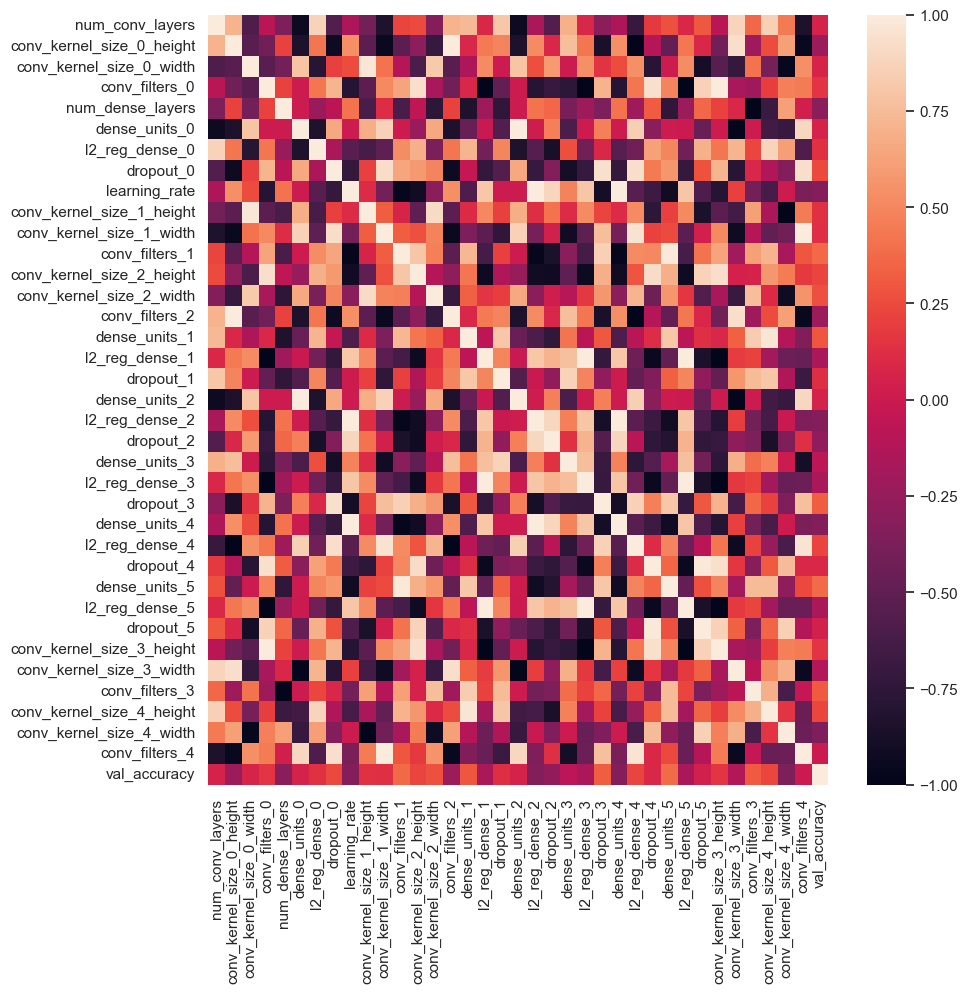

In [59]:
# correlation between everything
cols_to_remove = ['tuner/epochs', 'tuner/initial_epoch',
       'tuner/bracket', 'tuner/round','tuner/trial_id', 'trial_id', 'Model']
df_trials2 = df_trials.drop(columns = cols_to_remove)
plt.figure(figsize=(10,10))
sns.heatmap(df_trials2.corr())

df_trials2.corr()['val_accuracy'].sort_values(ascending=False)

- Only do 1 or 2 dense layers
- Play around with number of convolutional layers still (3-5 or more?)
- Include large number of convolutional filters
- Include dropout, but choose one dropout value across layers
    - Don't need to set to 0 probably
- Remove regularization until the last layer?

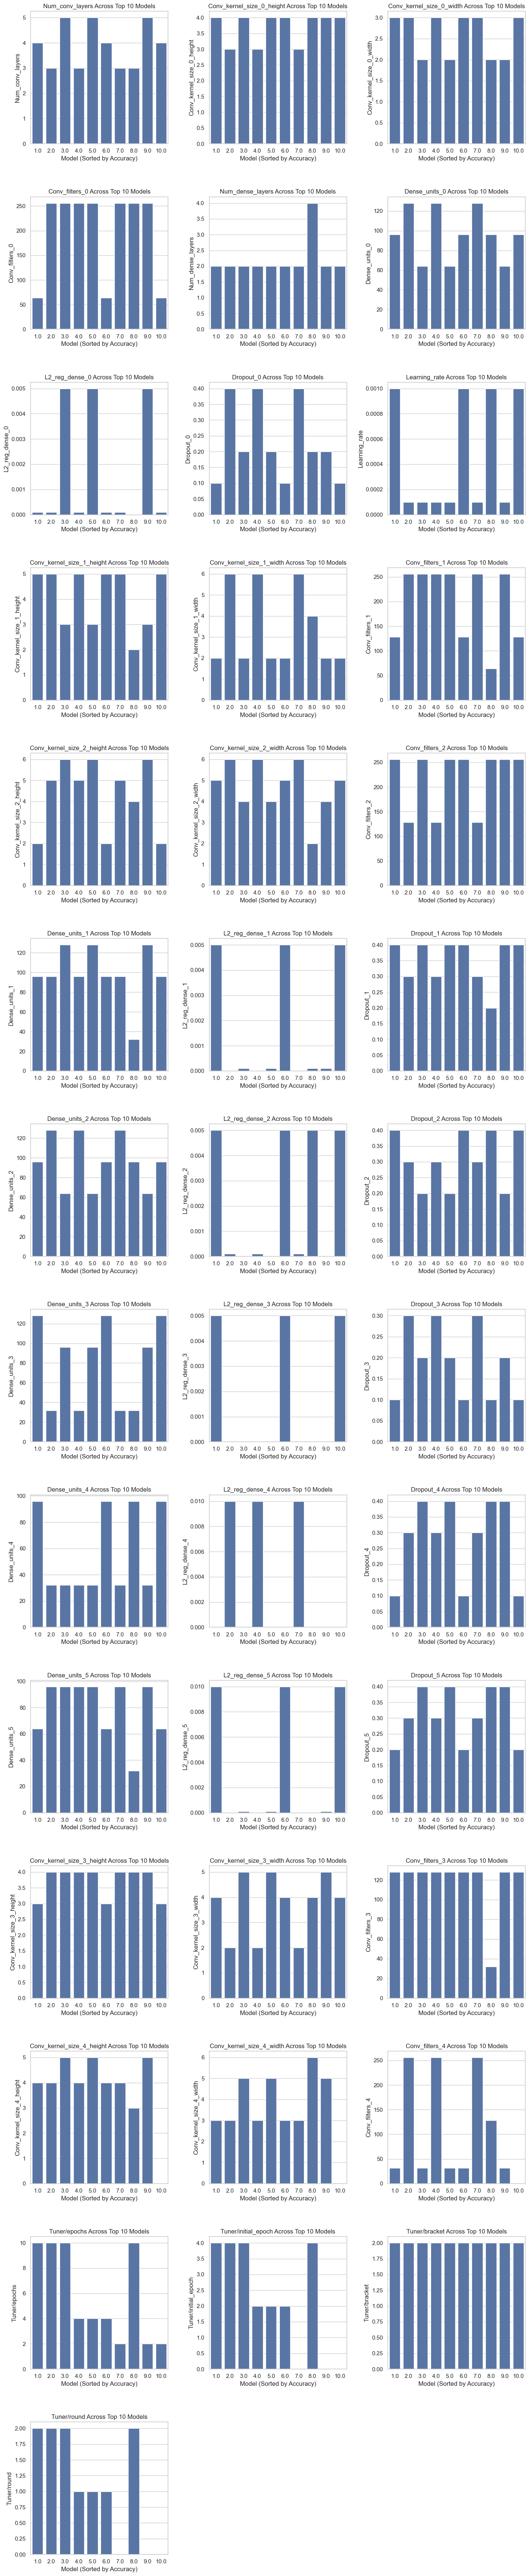

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only the top 10 models
df_trials = df_trials.head(10)

# Sort by validation accuracy
df_trials = df_trials.sort_values(by='val_accuracy', ascending=False)

# List of hyperparameters to plot
hyperparameters = df_trials.loc[:, 'num_conv_layers':'tuner/round'].columns.tolist()

# Set up the figure and subplots
num_params = len(hyperparameters)
cols = 3  # Set number of columns to 3
rows = (num_params + 2) // cols  # Calculate number of rows needed (round up if necessary)

# Set Seaborn style
sns.set(style="whitegrid")

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes for easy iteration (in case of a single row)
axes = axes.flatten()

# Loop through each hyperparameter and plot
for i, param in enumerate(hyperparameters):
    sns.barplot(x='Model', y=param, data=df_trials, order=df_trials['Model'], ax=axes[i])
    
    # Titles and labels
    axes[i].set_title(f'{param.capitalize()} Across Top 10 Models')
    axes[i].set_xlabel('Model (Sorted by Accuracy)')
    axes[i].set_ylabel(param.capitalize())
    
# Remove empty subplots if the number of hyperparameters is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)  # Padding between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # More padding between rows and columns

plt.show()

In [7]:
# get the best hyperparameters out:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

num_conv_layers: 4
conv_kernel_size_0_height: 4
conv_kernel_size_0_width: 3
conv_filters_0: 64
num_dense_layers: 2
dense_units_0: 96
l2_reg_dense_0: 0.0001
dropout_0: 0.1
learning_rate: 0.001
conv_kernel_size_1_height: 5
conv_kernel_size_1_width: 2
conv_filters_1: 128
conv_kernel_size_2_height: 2
conv_kernel_size_2_width: 5
conv_filters_2: 256
dense_units_1: 96
l2_reg_dense_1: 0.005
dropout_1: 0.4
dense_units_2: 96
l2_reg_dense_2: 0.005
dropout_2: 0.4
dense_units_3: 128
l2_reg_dense_3: 0.005
dropout_3: 0.1
dense_units_4: 96
l2_reg_dense_4: 1e-05
dropout_4: 0.1
dense_units_5: 64
l2_reg_dense_5: 0.01
dropout_5: 0.2
conv_kernel_size_3_height: 3
conv_kernel_size_3_width: 4
conv_filters_3: 128
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
conv_kernel_size_4_height: 4
conv_kernel_size_4_width: 3
conv_filters_4: 32


In [9]:
# train the best model on the full dataset

best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    validation_split = 0.2,
    callbacks=[stop_early]
)

test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# save the best model for future use
best_model.save('best_connect4_cnn-kennedy.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 6, 7, 64)       │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 7, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 7, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 7, 128)      │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │       516,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,111 (5.08 MB)

 Trainable params: 1,331,111 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 206s 17ms/step - accuracy: 0.4059 - loss: 1.5322 - val_accuracy: 0.5160 - val_loss: 1.2745
Epoch 2/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - accuracy: 0.5255 - loss: 1.2767 - val_accuracy: 0.5650 - val_loss: 1.1541
Epoch 3/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 205s 17ms/step - accuracy: 0.5550 - loss: 1.2333 - val_accuracy: 0.5729 - val_loss: 1.1632
Epoch 4/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 209s 17ms/step - accuracy: 0.5708 - loss: 1.2339 - val_accuracy: 0.5815 - val_loss: 1.1529
Epoch 5/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 201s 17ms/step - accuracy: 0.5777 - loss: 1.2751 - val_accuracy: 0.5772 - val_loss: 1.2551
Epoch 6/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 202s 17ms/step - accuracy: 0.5815 - loss: 1.3032 - val_accuracy: 0.5825 - val_loss: 1.3014
Epoch 7/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 212s 18ms/step - accuracy: 0.5808 - loss: 1.3976 - val_accuracy: 0.5989 - val_loss: 1.1984
Epoch 8/100
11974/11974 ━━━━━━━━━━━━━━━━━━━━ 205

KeyboardInterrupt: 

In [ ]:
# Train selected model on whole dataset


In [11]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

3742/3742 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step - accuracy: 0.5736 - loss: 1.1230
Test accuracy: 0.5740


## Test Model Against MCTS

In [ ]:
# load the best model
from tensorflow.keras.models import load_model

model1 = load_model('best_model_1.h5')